# scikit-qulacs チュートリアル

## scikit-qulacs とは 

量子回路シミュレータ [Qulacs-Osaka](https://github.com/Qulacs-Osaka/qulacs-osaka) ([Qulacs](https://github.com/qulacs/qulacs) の大阪大学バージョン) をバックエンドとした量子機械学習アルゴリズムのシミュレータです。scikit-learn の名前をもじっています。

## インストール
PyPI からインストールできます。
```
pip install skqulacs
```

## Quantum neural network
入力データ ${\boldsymbol x}$ に対して、学習パラメータ ${\boldsymbol \theta}$ を使って
$$y_{{\boldsymbol \theta}}({\boldsymbol x}) = \langle 0|U^\dagger({\boldsymbol \theta}, {\boldsymbol x}) O U({\boldsymbol \theta}, {\boldsymbol x})|0\rangle$$
の形でモデル $y_{{\boldsymbol \theta}}({\boldsymbol x})$ を構築する手法を量子ニューラルネットワークと呼びます。scikit-qulacs では `skqulacs.qnn` モジュールに実装されています。分類問題をとく `skqulacs.qnn.classifier` と回帰問題を解く `skqulacs.qnn.regressor` の２つがあります。

### `skqulacs.qnn.QNNClassifier` の使い方
例として、有名な `iris` データセットを分類する量子ニューラルネットワークを組んでみます。まず、以下のコードによって `scikit-learn` から `iris` データセットを取り出し、訓練データとテストデータに分けます。

In [25]:
import pandas as pd
from sklearn import datasets
from sklearn.model_selection import train_test_split

iris = datasets.load_iris()
df = pd.DataFrame(iris.data, columns=iris.feature_names)
x = df.loc[:, ["petal length (cm)", "petal width (cm)"]]
x_train, x_test, y_train, y_test = train_test_split(
    x, iris.target, test_size=0.25, random_state=0
)
x_train = x_train.to_numpy()
x_test = x_test.to_numpy()

変数はそれぞれ
- `x_train`: 訓練データの入力
- `y_train`: 訓練データのラベル
- `x_test`: テストデータの入力
- `y_test`: テストデータのラベル

です。

次に簡単な量子回路によってこれらの分類を行ってみます。

In [26]:
from skqulacs.circuit.pre_defined import create_qcl_ansatz
from skqulacs.qnn import QNNClassifier
from skqulacs.qnn.solver import Bfgs

nqubit = 5                      # qubitの数。必要とする入力、出力の次元数以上が必要である。
c_depth = 3                     # circuitの深さ。ニューラルネットワークでの隠れ層に対応する。
time_step = 1.                  # qcl_ansatz に必要となるパラメータ。横磁場イジングモデルによって発展させる時間を決める。
num_class = 3                   # 分類数（ここでは3つの品種に分類）
solver = Bfgs()                   # アルゴリズム。ほかには、`Adam()` や `NelderMead()` が使える。
maxiter = 20                    # ループの最大。これが多いほど、正確になるが、時間がかかる。
circuit = create_qcl_ansatz(nqubit, c_depth, time_step)     # LearningCircuitを作る
qcl = QNNClassifier(circuit, num_class, solver)     # モデル構築を行う
opt_loss, opt_params = qcl.fit(x_train, y_train, maxiter)                          # 学習
print("trained parameters", opt_params)
print("loss", opt_loss)

trained parameters [ 0.28369166  4.40355959  3.89182197  3.20140458 -0.01410486  1.63530003
  0.97069445  3.95026439  2.28163713  5.09875496  1.77777807  4.15023956
  1.17322681  4.83713152  4.33657993  3.22117396  3.73769708  6.03171236
  2.0875344   3.62461171  1.62362333  6.17615808  6.97707293  7.1335408
  0.72780524  3.96684159  0.57172788  3.71742879  5.86316949  3.61348709
  2.77441349  3.19267868  6.26489012  5.23838624  2.58767035  5.49513645
  1.77014433  2.28310896  2.2492472   2.58354394  3.88819215  6.24697777
  2.14927842  2.82751949  3.8789569 ]
loss 0.3550360589055038


テストデータと比べて結果を出力します。

In [27]:
from sklearn.metrics import f1_score
y_pred = qcl.predict(x_test)
print(f1_score(y_test, y_pred, average="weighted"))

0.9739522830846216


うまく分類できていることがわかります。

### `skqulacs.qnn.QNNRegressor` の使い方
回帰問題を解くには `QNNRegressor` を使います。ここでは $y=\sin(\pi x)$ を学習させてみます。まずデータセットを作ります。

In [28]:
import numpy as np
from numpy.random import default_rng

def generate_noisy_sine(x_min, x_max, num_x):
    rng = default_rng(0)
    x_train = [[rng.uniform(x_min, x_max)] for _ in range(num_x)]
    y_train = [np.sin(np.pi*x[0]) for x in x_train]
    mag_noise = 0.01
    y_train += mag_noise * rng.random(num_x)
    return np.array(x_train), np.array(y_train)
  
x_min = -1.0
x_max = 1.0
num_x = 80
x_train, y_train = generate_noisy_sine(x_min, x_max, num_x)
x_test, y_test = generate_noisy_sine(x_min, x_max, num_x)

作成したデータに対して学習を行います。

In [29]:
from skqulacs.qnn import QNNRegressor

n_qubit = 4
depth = 4
time_step = 0.5
solver = Bfgs()
maxiter=20
circuit = create_qcl_ansatz(n_qubit, depth, time_step, 0)
qnn = QNNRegressor(circuit, solver)
opt_loss, opt_params = qnn.fit(x_train, y_train, maxiter)
print("trained parameters", opt_params)
print("loss", opt_loss)

trained parameters [ 4.80281211  1.93928838 -0.5205007   0.36683164  4.82276275  6.47811525
  3.38919905  5.02087438  3.3718359   6.32019833  5.49131488  0.14543509
  5.4754958   0.66461726  4.68233889  1.42410867  5.53990554  3.79548094
  1.84638698  2.68947621  0.03457702  0.94699584  4.49461489  3.60827377
  3.89882872  2.59470479  6.22981776  6.1633591   4.24396167  3.91849499
  4.33407504  2.57338267  0.69187344  4.87367468  3.40637054  1.60695639
  3.30741867  5.46553484  5.94186833  2.24809352  3.59102784  2.02236503
  3.73409722  2.12315885  2.46061475  5.59375873  1.42727325  3.91560031]
loss 0.008509086067117136


訓練したモデルとテストデータを並べてプロットしてみます。

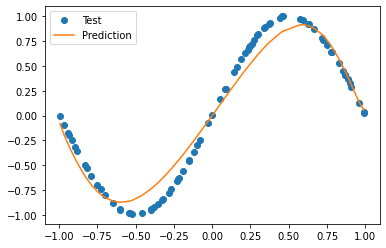

In [30]:
import matplotlib.pyplot as plt

y_pred = qnn.predict(x_test)
plt.plot(x_test, y_test, "o", label="Test")
plt.plot(np.sort(np.array(x_test).flatten()), np.array(y_pred)[np.argsort(np.array(x_test).flatten())], label="Prediction")
plt.legend()
plt.show()

よく学習できていることがわかります。

## 量子カーネル法
入力データ ${\boldsymbol x}$ を量子状態 $|\psi({\boldsymbol x})\rangle$ にマップし、この量子状態間の内積で定義されるカーネル関数
$$K({\boldsymbol x},{\boldsymbol x}')=|\langle \psi({\boldsymbol x})| \psi({\boldsymbol x}')\rangle|^2$$
を使ったカーネル法を量子カーネル法と呼びます。scikit-qulacs には、support vector classifier `skqulacs.qsvm.QSVC` と support vector regressor `skqulacs.qsvm.QSVR` の2つが実装されています。

### `skqulacs.qsvm.QSVC` の使い方
ここでは IBM のグループが論文 [Supervised learning with quantum-enhanced feature spaces](https://www.nature.com/articles/s41586-019-0980-2) で提案した $|\psi({\boldsymbol x})\rangle$ を使った分類を行います。この状態を作る量子回路は `skqulacs.circuit.create_ibm_embedding_circuit` によって作り出せます。

まずデータセットを準備します。

In [31]:
iris = datasets.load_iris()
df = pd.DataFrame(iris.data, columns=iris.feature_names)
x = df.loc[:, ["petal length (cm)", "petal width (cm)"]]
x_train, x_test, y_train, y_test = train_test_split(
    x, iris.target, test_size=0.25, random_state=0
)
x_train = x_train.to_numpy()
x_test = x_test.to_numpy()

回路を作成し、QSVC を訓練、予測値を出力させます。

In [32]:
from skqulacs.circuit import create_ibm_embedding_circuit
from skqulacs.qsvm import QSVC
n_qubit = 4                         # x_train の次元数以上必要。あまり小さいと結果が悪くなる。
circuit = create_ibm_embedding_circuit(n_qubit)
qsvm = QSVC(circuit)
qsvm.fit(x_train, y_train)
y_pred = qsvm.predict(x_test)

評価してみます。

In [33]:
print(f1_score(y_test, y_pred, average="weighted"))

0.8978070175438595


qnn よりも悪い結果となりました。回路形がこのデータセットに適していないからだと考えられます。

### `skqulacs.qsvm.QSVR` の使い方
同様の回路を使い、回帰を行ってみます。QNN の場合と同様に、$\sin(\pi x)$ を学習します。まずデータセットを作ります。

In [34]:
x_min = -1.0
x_max = 1.0
num_x = 1000
x_train, y_train = generate_noisy_sine(x_min, x_max, num_x)
x_test, y_test = generate_noisy_sine(x_min, x_max, num_x)

学習します。

In [35]:
from skqulacs.qsvm import QSVR
n_qubit = 4                         # x_train の次元数以上必要。あまり小さいと結果が悪くなる。
circuit = create_ibm_embedding_circuit(n_qubit)
qsvm = QSVR(circuit)
qsvm.fit(x_train, y_train)
y_pred = qsvm.predict(x_test)

学習結果をプロットしてみます。

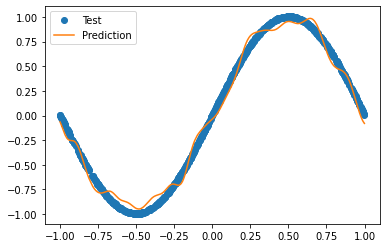

In [36]:
plt.plot(x_test, y_test, "o", label="Test")
plt.plot(np.sort(np.array(x_test).flatten()), np.array(y_pred)[np.argsort(np.array(x_test).flatten())], label="Prediction")
plt.legend()
plt.show()

うまく学習できています。

## 用意されている量子回路

scikit-qulacs では代表的な論文で発表されている機械学習用量子回路を手軽に使えるようにするため、量子回路の実装に努めています。機械学習用量子回路は `LearningCircuit` クラスのインスタンスとして実装されていて、`skqulacs.circuit` モジュールにある `create_...()` という関数を呼ぶことにより作成可能です。

代表的なansatzとして、
- create_farhi_neven_ansatz(n_qubit: int, c_depth: int, seed: Optional[int] = None): [arXiv:1802.06002](https://arxiv.org/pdf/1802.06002)
![farhi_neven_ansatz](figures/circuit_visualize/farhi_neven_ansatz.png)
- create_ibm_embedding_circuit(n_qubit: int): [arXiv:1804.11326](https://arxiv.org/abs/1804.11326) 
![ibm_embedding_circuit](figures/circuit_visualize/ibm_embedding_circuit.png)

が用意されています。

他に利用可能な量子回路のリストについては[このページ](circuit_visualize.ipynb)をご覧ください。

基本的には `QNNClassifier` などの引数として与えることを推奨しますが、自前で新たなアルゴリズムを作りたいときなど、これらの量子回路を直接扱いたいときもあると思います。以下に使用例を掲載します。

以下のコードで QCL ansatz を作成します。

In [37]:
n_qubits = 4
c_depth = 4
time_step = 1.
ansatz = create_qcl_ansatz(n_qubits, c_depth, time_step)

`LearningCircuit` にセットされている訓練パラメータは `get_parameters()` によって取り出せます。

In [38]:
parameters = ansatz.get_parameters()
print(len(parameters), parameters)      # show parameters in the circuit. Parameters are chosen randomly within create_qcl_ansatz()

48 [4.329568604933745, 4.998166249467968, 2.648145949874237, 3.485692435043816, 0.5118263616749738, 1.4170948380133743, 0.9559702309628019, 0.8515631390723315, 1.6214027300714766, 1.3993192595471198, 6.035620613982063, 0.4323263817919768, 6.097886371032433, 1.7953431038863623, 2.8132472691910526, 0.3480854560452386, 4.418466613235093, 2.3647639731901884, 4.743289340164865, 1.9576646172007313, 2.469129761064283, 3.1309198400644673, 5.753416795919882, 2.5266377130517848, 3.6460732090181383, 2.8024819634411524, 4.339062200487985, 0.1398094511681748, 0.5416943860086613, 4.867232624039765, 3.9241946706637845, 1.5508794465224287, 3.4416516882656305, 3.4430366001219648, 3.594889032930406, 5.9370414701811765, 2.466149941275912, 1.0829770815147415, 4.643692763302861, 4.553067292067355, 1.2702497699005406, 3.4191890734750823, 5.395687896117605, 5.186820884674701, 1.3369559905948418, 5.666895095181762, 6.167724175207953, 2.855599991630522]


`update_parameters()` を使うと、パラメータを更新できます。以下では全てのパラメータをゼロにセットします。

In [39]:
ansatz.update_parameters(np.zeros(len(parameters)))
print(ansatz.get_parameters())

[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]


`run(x)` を使うと、入力データ ${\boldsymbol x}$ に対して、初期状態 $|0\rangle$ に量子回路を作用させたときの出力状態が `qulacs.QuantumState` として返されます。QCL ansatz は `n_qubits` 次元までの入力を扱うことのできる ansatz なので、今回は 2 次元入力を与えます。

多くの回路では、データ次元数をaとして、それが`n_qubits`以下の場合、回路のx番目には、n_qubits % a 番目の入力が入ります。

In [40]:
state = ansatz.run([np.pi/2, np.pi/2])
print(state.get_vector())

[ 0.30869612+0.13283004j -0.0759879 -0.06176279j -0.21316566-0.1438611j
  0.21877642+0.06614673j -0.33638863+0.12504632j  0.24610584+0.23178805j
  0.05948781+0.05711437j  0.03556247-0.08914448j  0.03556247-0.08914448j
  0.05948781+0.05711437j  0.24610584+0.23178805j -0.33638863+0.12504632j
  0.21877642+0.06614673j -0.21316566-0.1438611j  -0.0759879 -0.06176279j
  0.30869612+0.13283004j]


## ユーザー定義の量子回路を学習に利用する
ここでは自分でオリジナルの量子回路を定義し、それを学習に利用する方法を説明します。scikit-qulacs では、`LearningCircuit` クラスによって量子回路を表現しています。これは qulacs の `ParametricQuantumCircuit` のラッパーとなっていて、入力データと訓練される回路パラメータを一元管理し、それらをすべて qulacs の parametric gate で扱えるようにしたものです。

`LearningCircuit` クラスは qulacs の `ParametricQuantumCircuit` のうちの主要な `add_.._gate()` 系のメソッドを機能そのままにラップしています。それに加えて、`ParametricQuantumCircuit` を拡張する機能として、以下のメソッドが追加されています。

- `add_input_RX_gate(index, input_func)`, `add_input_RY_gate(index, input_func)`, `add_input_RZ_gate(index, input_func)`: 入力データを入れるためのゲートを追加します。引数にはそれぞれ以下のものを与えます。
    - `index`: そのゲートを作用させる量子ビット
    - `input_func`: 入力データ ${\boldsymbol x}$ -> 回転ゲートの回転角 $\phi = \phi({\boldsymbol x})$ の変換を行う関数。回路実行時には `input_func(x)` が角度にセットされます。
- `add_parametric_input_RX_gate(index, parameter, input_func)` (RY, RZ も同様) :入力データと訓練パラメータが同時に含まれているようなゲートを追加します。
    - `index`: そのゲートを作用させる量子ビット
    - `parameter`: 実数の訓練パラメータ $\theta$
    - `input_func`: 入力データ ${\boldsymbol x}$, 訓練パラメータ $\theta$ -> 回転ゲートの回転角 $\phi = \phi(\theta, {\boldsymbol x})$ の変換を行う関数。回路実行時には `input_func(theta, x)` が角度にセットされます。

例えば以下のコードは、各量子ビットに ${\boldsymbol x} = \{x_i\}_{i=0}^3$ の各成分を $R_y$ ゲートで入力したあと、各量子ビットを訓練可能な $R_y$ ゲートで変換し、最後に全ての量子ビットにアダマールゲートを一度だけ作用させる `LearningCircuit` を構成するコードです。(例のためだけに書いていて、特に意味は無い回路です。) 

In [41]:
from skqulacs.circuit import LearningCircuit
n_qubit = 4
circuit = LearningCircuit(n_qubit)
for i in range(n_qubit):
    circuit.add_input_RY_gate(i, lambda x: x[i%2])  # input 2 dimensional x into the circuit by RY rotation
for i in range(n_qubit):
    circuit.add_parametric_RY_gate(i, 0.)           # first argument is qubit index, second argument is parameter
for i in range(n_qubit):
    circuit.add_H_gate(i)

`run()` メソッドによって初期状態 $|0\rangle$ にこの回路を作用させたときの量子状態が返されます。このメソッドは入力データ ${\boldsymbol x}$ を引数として取ります。上の回路は 2 次元の ${\boldsymbol x}$ を取れるように設計したので、2次元の入力を与えます。

In [42]:
x = [np.pi/2,np.pi/2]
state = circuit.run(x)
print(state.get_vector())

[-6.93889390e-18+0.j -1.96261557e-17+0.j -2.08166817e-17+0.j
 -2.77555756e-17+0.j -2.08166817e-17+0.j  1.96261557e-17+0.j
 -6.93889390e-18+0.j  0.00000000e+00+0.j -2.08166817e-17+0.j
  1.96261557e-17+0.j -6.93889390e-18+0.j  2.77555756e-17+0.j
 -6.93889390e-18+0.j  5.88784672e-17+0.j  9.02056208e-17+0.j
  1.00000000e+00+0.j]


予想どおりの出力が得られることが確認できます。